In [1]:
import spikeinterface.full as si
from spikeinterface.sorters import get_default_sorter_params, get_sorter_params_description
import probeinterface as pi
from spikeinterface_gui import run_mainwindow
from pathlib import Path
import json
import woodsort
import warnings


In [2]:
# Spike sorting pipeline for the H7400 dataset
# Experimenter: Anna Rastedt
# Acquired: June 2025 - 

### Parameters set manually ### 

# path to the recording folder (the folder containing the OpenEphys folder YYYY-MM-DD_hh-mm-ss)
recfolder_path = '/home/avadher/Data/Anna/H7407-250815/'

# set parameters for probe
shank_groups = [0, 1, 2, 3, 4, 5] # specify which groups in the xml file are shanks to be sorted (0-base)
custom_probe_path = 'probe_layouts/Buzsaki64sp.json'
excluded_channels = ["CH17", "CH18", "CH19", "CH20"]

# set parameters for spike sorting
sorter = "mountainsort5"
n_jobs = 12  # number of CPU cores to run everything on 
analyzer_metrics_path = 'params/default_analyzer_metrics.json' # list of metrics for Analyzer to compute 

# set parameters for tracking 
ttl_channel = 69 # channel in DAT file where camera TTL pulses are registered (0-base)
column_names=['x_left','y_left','x_right','y_right']  # keep the same names but change order as recorded
pixel_width = 0.1529  # size of one pixel in cm, get from video by typing pixelwidth in terminal 
min_spacing = 3  # minimum spacing between two LEDs in cm 
max_spacing = 8  # maximum spacing between two LEDs in cm 


### parameters set automatically ### 

# Set paths 
recfolder_path = Path(recfolder_path)
analyzer_metrics_path = Path(woodsort.__file__).parent / analyzer_metrics_path
custom_probe_path = Path(woodsort.__file__).parent / custom_probe_path
session_name = recfolder_path.name
spikesorting_folder_name = f"{session_name}_sorting_{sorter}"
spikesorting_path =recfolder_path / spikesorting_folder_name
analyzer_folder_name = f"{session_name}_analyzer_{sorter}"
analyzer_path = recfolder_path / analyzer_folder_name
curation_path = analyzer_path / 'spikeinterface_gui/curation_data.json'
print(curation_path)
print(analyzer_path)
# Set the number for cores for parallel processing 
si.set_global_job_kwargs(n_jobs=n_jobs) 

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


/home/avadher/Data/Anna/H7407-250815/H7407-250815_analyzer_mountainsort5/spikeinterface_gui/curation_data.json
/home/avadher/Data/Anna/H7407-250815/H7407-250815_analyzer_mountainsort5


Probe is a ProbeGroup! Using the first probe
Using XML file: /home/avadher/Data/Anna/H7407-250815/2025-08-15_10-48-25/Record Node 108/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/continuous.xml
Probe updated with Neuroscope mapping
Excluded channels: CH17, CH18, CH19, CH20
Applying high-pass filter (300-6000 Hz)...
Detecting and removing bad channels...
Bad channel IDs (0-based): []
Channel mapping saved to /home/avadher/Data/Anna/H7407-250815/ChannelMapping.csv 

write_binary_recording 
engine=process - n_jobs=12 - samples_per_chunk=30,000 - chunk_memory=1.14 MiB - total_memory=13.73 MiB - chunk_duration=1.00s
Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 0.067 seconds ***
Running phase 1 sorting
Number of channels: 10
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [-14.5 140. ]
Channel 1: [-17. 180.]
Channel 2: [-9.5 60. ]
Channel 3: [-12.

estimate_sparsity (workers: 12 processes):   0%|          | 0/11161 [00:00<?, ?it/s]

compute_waveforms (workers: 12 processes):   0%|          | 0/11161 [00:00<?, ?it/s]

noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Fitting PCA:   0%|          | 0/41 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/41 [00:00<?, ?it/s]

Compute : spike_amplitudes + spike_locations (workers: 12 processes):   0%|          | 0/11161 [00:00<?, ?it/s…

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/41 [00:00<?, ?it/s]

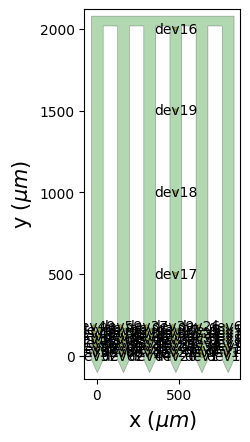

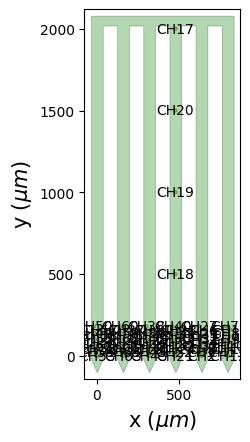

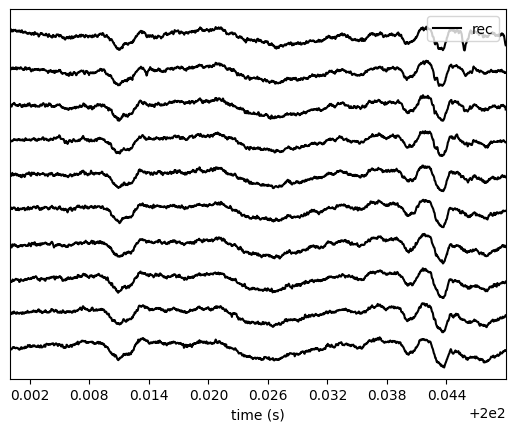

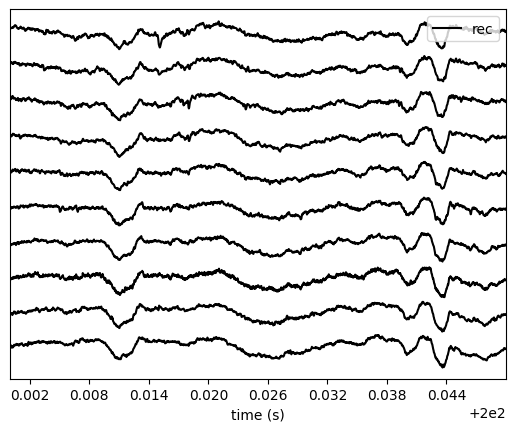

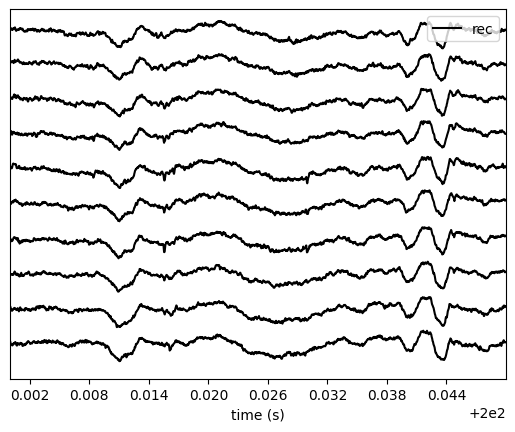

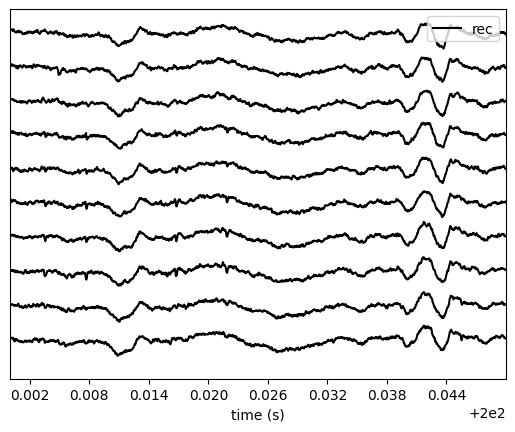

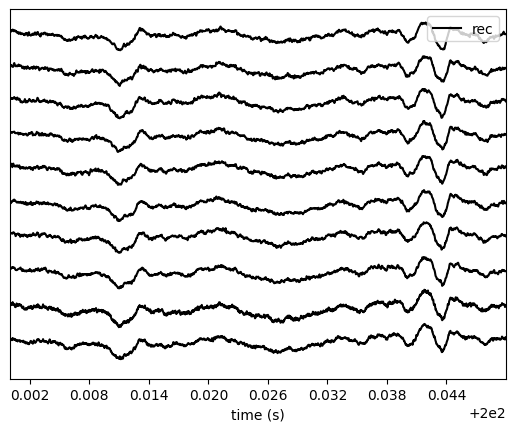

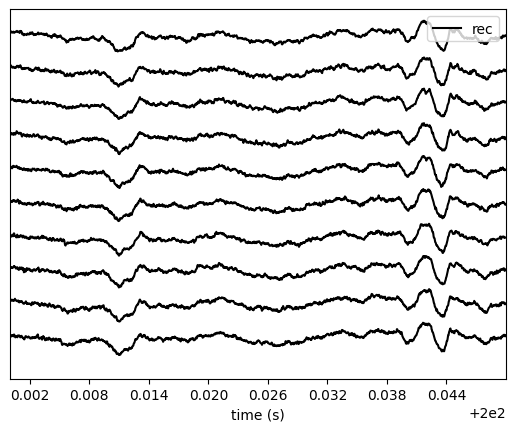

In [3]:
### Spike sorting ### 

# Load recording and probe, preprocess and fill channel indices from Neuroscope
recording = si.read_openephys(recfolder_path,stream_id='0')
probe = pi.read_probeinterface(custom_probe_path)
recording = woodsort.preprocessing.process_openephys_with_neuroscope(
    recording=recording, 
    probe=probe,
    session_path=recfolder_path,
    shank_groups=shank_groups,
    excluded_channels=excluded_channels,
    plot_probe=True,
    plot_range=[200, 200.05])

# Run spike sorting
sorting = si.run_sorter(
    recording=recording, 
    sorter_name=sorter, 
    remove_existing_folder=True, 
    folder=spikesorting_path)

## Compute analyzer
analyzer_metrics = json.load(open(analyzer_metrics_path))
si.create_sorting_analyzer(
    recording=recording,
    sorting=sorting,
    format="binary_folder",
    folder=analyzer_path,
    overwrite=True,
).compute(analyzer_metrics)



In [6]:
### Manual curation ###

analyzer = si.load_sorting_analyzer(analyzer_path)
run_mainwindow(analyzer, mode="desktop", curation=True)



Sync metadata written to: /home/avadher/Data/Anna/H7407-250815/MetadataOpenephys.txt

Extracting recording boundaries...
Extracting start and end times: /home/avadher/Data/Anna/H7407-250815/2025-08-15_10-48-25/Record Node 108/experiment1/recording1
Extracting start and end times: /home/avadher/Data/Anna/H7407-250815/2025-08-15_10-48-25/Record Node 108/experiment1/recording2
Extracting start and end times: /home/avadher/Data/Anna/H7407-250815/2025-08-15_10-48-25/Record Node 108/experiment1/recording3
Extracting start and end times: /home/avadher/Data/Anna/H7407-250815/2025-08-15_10-48-25/Record Node 108/experiment1/recording4
Extracting start and end times: /home/avadher/Data/Anna/H7407-250815/2025-08-15_10-48-25/Record Node 108/experiment1/recording5
Extracting start and end times: /home/avadher/Data/Anna/H7407-250815/2025-08-15_10-48-25/Record Node 108/experiment1/recording6

Epoch timestamps saved to: /home/avadher/Data/Anna/H7407-250815/EpochTimestamps.csv


Sync metadata written t

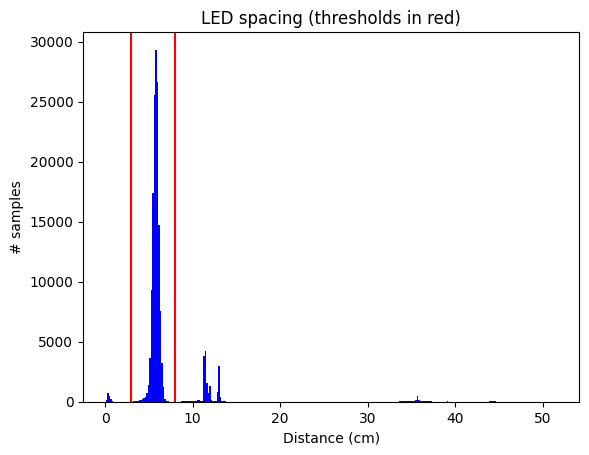

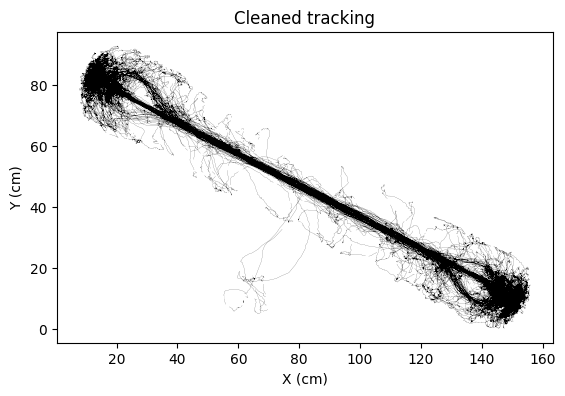

In [5]:
### Get other data from the recording ###

# Get OpenEphys metadata
metadata = woodsort.helper_functions.get_metadata_openephys(recfolder_path)

# get epochs
epochs = woodsort.helper_functions.get_epochs_openephys(
    recfolder_path, 
    save_path =recfolder_path)

# get OpenEphys metadata
woodsort.helper_functions.get_metadata_openephys(
        recfolder_path, 
        save_path =recfolder_path)

# align tracking
aligned_tracking = woodsort.tracking.align_tracking_bonsai(
    recfolder_path=recfolder_path, 
    ttl_channel=ttl_channel, 
    column_names=column_names, 
    save_path=recfolder_path)

# process tracking
processed_tracking = woodsort.tracking.process_tracking_bonsai(
        aligned_tracking,   
        pixel_width=pixel_width,      # conversion factor: cm per pixel
        min_spacing=min_spacing,      # minimum allowed LED spacing (cm)
        max_spacing=max_spacing,  
        save_path=recfolder_path,  # maximum allowed LED spacing (cm)
        plot=True)             # whether to show diagnostic plot

# Extract LFP
#woodsort.lfp.extract_lfp_openephys(recfolder_path)


In [6]:
si.bandpass_filter?